In [1]:
from openpyxl import Workbook
from openpyxl import load_workbook
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
directory_in_str = "C:\\Users\\Edward\\OneDrive\\Documents\\University\\Fourth Year\\Thesis\\Papers\\ExcelDataCollection\\Complete\\"
#print(directory_in_str)
directory = os.fsencode(directory_in_str)

COLUMN_NAMES=['TotalT','Temp','LSR','CA','Size','Mass','Moisture', 'IsoT', 'HeatT', 'Ramp', 'F_A', 'F_Gal', 'F_Glu',
            'F_X', 'F_M', 'F_R', 'A', 'Gal', 'Glu','X', 'M', 'R', 'Furf', 'HMF', 'Source']

masterDF = pd.DataFrame(columns=COLUMN_NAMES)
print(len(masterDF.columns))
print(masterDF.columns)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    absPath = directory_in_str + filename
    if filename.endswith(".xlsx"): 
        wb = load_workbook(filename = absPath, data_only = True) 
        ws = wb["Data"]
        ws.delete_rows(1,2)
        df = pd.DataFrame(ws.values, columns=COLUMN_NAMES[:-1])
        df['Source'] = filename
        #print("1", df.at[1, 'Temp'])
        masterDF = pd.concat([masterDF, df], ignore_index=True)
        #masterDF = masterDF.append(df)
        #print("2",masterDF.at[1, 'Temp'])
        continue
    else:
        continue
        
#masterDF = masterDF.astype(float)
masterDF.reset_index()

for i in masterDF.index:
    masterDF.at[i, 'HeatT'] = (masterDF.at[i, 'Temp'] - 25) / masterDF.at[i, 'Ramp']
    #print(type(masterDF.at[i, 'TotalT']))
    #print((masterDF.at[i, 'Temp']))
    if masterDF.at[i, 'TotalT'] is None:
        masterDF.at[i, 'TotalT'] =  masterDF.at[i, 'HeatT'] +  masterDF.at[i, 'IsoT']
    if masterDF.at[i, 'IsoT'] is None:
        masterDF.at[i, 'IsoT'] =  masterDF.at[i, 'TotalT'] -  masterDF.at[i, 'HeatT']
        
masterDF['X'].fillna(0, inplace=True)
        
masterDF.to_csv("data.csv", index=False)

25
Index(['TotalT', 'Temp', 'LSR', 'CA', 'Size', 'Mass', 'Moisture', 'IsoT',
       'HeatT', 'Ramp', 'F_A', 'F_Gal', 'F_Glu', 'F_X', 'F_M', 'F_R', 'A',
       'Gal', 'Glu', 'X', 'M', 'R', 'Furf', 'HMF', 'Source'],
      dtype='object')


(591, 26)


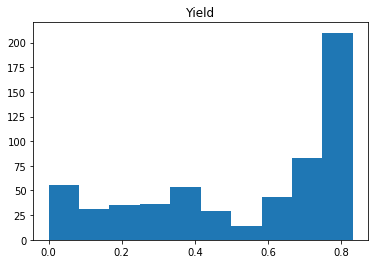

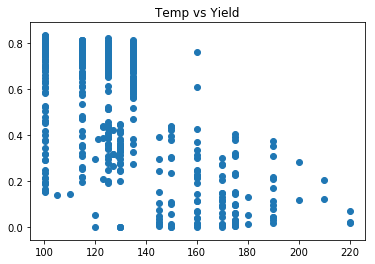

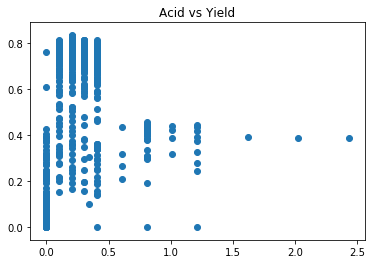

In [20]:
#Prepping Data
data = pd.read_csv("data.csv")
##Making new columns
data['Yield'] = data['X'] * data['LSR'] / (1000 * (data['F_X']/100)) #1000 is density of water in g/L, X is in g/L

X = data[['TotalT','Temp','LSR','CA','Size','Mass','Moisture', 'IsoT', 'HeatT', 'Ramp','F_X']]
Y = data['X']

# print(data.head())
print(data.shape)
# print(data['Yield'].max())

#Plotting
f1 = plt.figure()
f2 = plt.figure()
f3 = plt.figure()

ax1 = f1.add_subplot(111)
ax1.hist(data['Yield'])
ax1.set_title("Yield")


ax2 = f2.add_subplot(111)
ax2.scatter(data['Temp'], data['Yield'])
ax2.set_title("Temp vs Yield")

ax3 = f3.add_subplot(111)
ax3.scatter(data['CA'], data['Yield'])
ax3.set_title("Acid vs Yield")


plt.show()


In [17]:
#Multiple Linear Regression
from sklearn import linear_model
import statsmodels.api as sm




# with sklearn
##Ridge
#Split train test set
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print('Score', regr.score(X,Y))


Intercept: 
 3.832075273916832
Coefficients: 
 [-1.90520773e-01  2.00706235e-02 -5.34968936e-01  9.13983840e+00
  2.22729195e-02  3.22246903e-04  4.80567124e-02  2.04770722e-01
 -3.95291496e-01 -2.48915248e-01  9.00687550e-01]
Score 0.2939333173821773


In [12]:
#SVM Models
from sklearn import svm
from sklearn.svm import LinearSVC
#Can't do because output is not categorical


newModel = 1

data = pd.read_csv("test.csv")
data = data.sample(frac=1).reset_index(drop=True)
X = data[['TotalT','Temp','LSR','CA','Size','Mass','Moisture', 'IsoT', 'HeatT', 'Ramp','F_X']]
Y = data['X']

print(X, Y)
# print(Y_train.size)
# print(X_train.shape[0])
#
# print(Y_train.head().to_string())
# print(X_train.head().to_string())

numValidation = int(Y.size/10)
print(numValidation)

X_valid, Y_valid = X[-numValidation:], Y[-numValidation:]
X_train, Y_train = X[:-numValidation], Y[:-numValidation]


Y_valid_arr = Y_valid.values
np.savetxt("y_valid", Y_valid_arr)

# if newModel:
#     #clf = svm.SVC(gamma=0.01)
#     clf = LinearSVC(random_state=0, tol=1e-10, verbose=True, max_iter=10000, dual=False, C=0.1)
#     clf.fit(X_train, Y_train)

# else:
#     clf = joblib.load('svcVader.joblib')


# ##SavingTrainedModel
# joblib.dump(clf, 'svcVaderWithPer.joblib')

#clf = svm.SVC(gamma=0.01)
clf = LinearSVC(random_state=0, tol=1e-10, verbose=True, max_iter=10000, dual=False, C=0.1)
clf.fit(X_train, Y_train)

print("finished training")

clfOutputs = clf.predict(X_valid)

###Checking Accuracy
#for i in range(len(clfOutputs)):
numCorrect = 0
for i in range(len(Y_valid_arr)):
    if clfOutputs[i] == Y_valid_arr[i]:
        numCorrect += 1


print("num Correct is ", numCorrect)

percentCorrect = float(numCorrect) / Y_valid.size * 100

print("% Correct is: " , percentCorrect)


        TotalT  Temp    LSR       CA    Size           Mass  Moisture  \
0   255.000000   160   4.76  0.00000  5.0000  263200.000000      39.0   
1    37.142857   180  15.00  0.00000  0.3250      37.500000       0.0   
2   500.000000   150   3.70  0.00000  2.0000      21.276596      10.0   
3    30.000000   150   3.70  0.00000  2.0000      21.276596      10.0   
4   360.000000   160   4.76  0.00000  5.0000  263200.000000      39.0   
5    11.500000   140  10.00  0.00000  0.2985       2.000000       0.0   
6   240.000000   160   4.76  0.00000  5.0000  263200.000000      39.0   
7    51.093750   160   6.00  0.00000  5.0000     671.428571      10.5   
8   103.500000   160  10.00  0.00000  0.2985       2.000000       0.0   
9    42.857143   220  15.00  0.00000  0.3250      37.500000       0.0   
10  140.714286   170  15.00  0.00000  0.3250      37.500000       0.0   
11  129.500000   120  10.00  0.00000  0.2985       2.000000       0.0   
12  101.500000   140  10.00  0.00000  0.2985       

ValueError: Unknown label type: 'continuous'

In [ ]:
##Random Forest

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import sklearn

data = pd.read_csv("test.csv")
data = data.sample(frac=1).reset_index(drop=True)
X = data[['TotalT','Temp','LSR','CA','Size','Mass','Moisture', 'IsoT', 'HeatT', 'Ramp','F_X']]
Y = data['X']


#Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#Scaling Data
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

#Training
regressor = RandomForestRegressor(n_estimators=20, random_state=0)  
regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test)



#Evaluation
print('average', y_test.mean())
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


#Getting Shape of Forest
params = regressor.get_params()
path = regressor.decision_path(X_train)

#print(params)
#print(path)

In [166]:
#Keras
from keras.models import Sequential
from keras.layers import Dense

data = pd.read_csv("test.csv")
data = data.sample(frac=1).reset_index(drop=True)
X = data[['TotalT','Temp','LSR','CA','Size','Mass','Moisture', 'IsoT', 'HeatT', 'Ramp','F_X']]
Y = data['X']


#Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#Scaling Data
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

model = Sequential()

model.add(Dense(units=4, activation='relu', input_dim=11))
model.add(Dense(units=1, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

model.fit(X_train, y_train, epochs=40, batch_size=32)

loss_and_metrics = model.evaluate(X_test, y_test, batch_size=128)
                                  
classes = model.predict(X_test, batch_size=128)



56 56
15 15
Epoch 1/40
56/56 [==============================] - 0s 6ms/step - loss: 480.4788 - acc: 0.0000e+00
Epoch 2/40
56/56 [==============================] - 0s 71us/step - loss: 480.4788 - acc: 0.0000e+00
Epoch 3/40
56/56 [==============================] - 0s 60us/step - loss: 480.4788 - acc: 0.0000e+00
Epoch 4/40
56/56 [==============================] - 0s 71us/step - loss: 480.4787 - acc: 0.0000e+00
Epoch 5/40
56/56 [==============================] - 0s 162us/step - loss: 480.4787 - acc: 0.0000e+00
Epoch 6/40
56/56 [==============================] - 0s 107us/step - loss: 480.4788 - acc: 0.0000e+00
Epoch 7/40
56/56 [==============================] - 0s 88us/step - loss: 480.4788 - acc: 0.0000e+00
Epoch 8/40
56/56 [==============================] - 0s 107us/step - loss: 480.4787 - acc: 0.0000e+00
Epoch 9/40
56/56 [==============================] - 0s 116us/step - loss: 480.4788 - acc: 0.0000e+00
Epoch 10/40
56/56 [==============================] - 0s 71us/step - loss: 480.4788 - 